In [2]:
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

In [3]:
!git clone https://github.com/chaklam-silpasuwanchai/NLP.git
%cd "/content/NLP/Assignment/a3 dependency parsing"

Cloning into 'NLP'...
remote: Enumerating objects: 800, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 800 (delta 102), reused 176 (delta 29), pack-reused 522
Receiving objects: 100% (800/800), 236.11 MiB | 28.34 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (135/135), done.
/content/NLP/Assignment/a3 dependency parsing


## Assignment 3: Dependency Parsing

### Estimated Time: ~10 hours

This assignment will build a neural dependency parser using PyTorch.  In part 1, we will review two general neural network techniques (Adam optimization and Dropout).  In part 2, we will implement and train a dependency parser using techniques from part 1.

## Part 1.  Adam Optimization and Dropout

### a) Adam

Recall the SGD update rule:

$$\theta = \theta - \alpha\triangledown_\theta J_{\text{minibatch}}(\theta)$$

where $\theta$ is a vector containing all of the model parameters, $J$ is the loss function, $\triangledown_\theta J_{\text{minibatch}}(\theta)$ is the gradient of the loss function, and $\alpha$ is the learning rate.  Adam is another possible update rule with two additional steps.

- (2 pts) First, Adam uses a trick called momentum by keep track of $\mathbf{m}$, a rolling average of the gradients:

$$\mathbf{m} = \beta_1 \mathbf{m} + (1-\beta_1)\triangledown_\theta J_{\text{minibatch}}(\theta)$$
$$\theta = \theta - \alpha \mathbf{m}$$

  where $\beta_1$ is a hyperparameter between 0 and 1 (often set to 0.9).  Briefly explain in 2-4 sentences (just give an intuition) how using $\mathbf{m}$ stops the updates from varying as much and why this low variance may be helpful to learning, overall.
  
#### <font color="red">Write your answer here.</font> 

'momentum' helps to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the past gradients step to determine the next step descent. This average of past steps helps achieve the tendency of lower variance, which enables the model not to OVERFIT.


reference: https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218

---



- (2 pts) Adam extends the idea of momentum with the trick of adaptive learning rates by keep track of $\mathbf{v}$, a rolling average of the magnitudes of the gradients:

$$\mathbf{m} = \beta_1 \mathbf{m} + (1 - \beta_1)\triangledown_\theta J_{\text{minibatch}}(\theta)$$
$$\mathbf{v} = \beta_2 \mathbf{v} + (1 - \beta_2)(\triangledown_\theta J_{\text{minibatch}}(\theta) \circ \triangledown_\theta J_{\text{minibatch}}(\theta))$$
$$\theta = \theta - \alpha \mathbf{m} \mathbin{/} \sqrt{\mathbf{v}}$$

where $\circ$ and $\mathbin{/}$ denote elementwise multiplication and division (not dot product!).  $\beta_2$ is a hyperparameter between 0 and 1 (often set to 0.99).  Since Adam divides the update by $\sqrt{\mathbf{v}}$, what kinds of weights will receive larger update and smaller update?  Give some simple example of how.  Why might this help with learning?

#### <font color="red">Write your answer here.</font> 

Since the update has  $\sqrt{\mathbf{v}}$ as denominator, the weight will receive larger update as $\sqrt{\mathbf{v}}$ gets smaller, that is the rolling average of previous gradients is small. Large update when the gradient is small makes possible to the model to conquer getting stuck at the local minima, and reach the global minima instead.






---
### b) Dropout

Dropout is a regularization technique.  During training, dropout randomly sets units in the hidden layer $\mathbf{h}$ to zero with probabilty $p_{\text{drop}}$ (dropping different units each minibatch), and then multiplies $\mathbf{h}$ by a constant $\gamma$.  We can write this as:

$$\mathbf{h}_{\text{drop}} = \gamma \mathbf{d} \circ \mathbf{h}$$

where $\mathbf{d} \in \{0, 1\}^{D_h}$ ($D_h$ is the size of $\mathbf{h}$) is a mask vector where each entry is 0 with probability $p_{\text{drop}}$ and 1 with probability ($1 - p_{\text{drop}}$). For the gamma constant, $\gamma$ is chosen such that the expected value of $\mathbf{h}_{\text{drop}}$ is $\mathbf{h}$ 

$$\mathbb{E}_{\text{p_drop}}[\mathbf{h}_{\text{drop}}]_i = h_i$$

for all $i \in \{1, \cdots, D_h\}$

- (2 pts) What must $\gamma$ equal in term of $p_\text{drop}$?  Briefly justify your answers or show your math derivation using the equations given above.

#### <font color="red">Write your answer here.</font> 

$$\mathbf{h}_{\text{drop}} = \gamma \mathbf{d} \circ \mathbf{h}$$

$$h_i = \mathbb{E}_{\text{p_drop}}[\mathbf{h}_{\text{drop}}]_i $$

$$h_i = \mathbb{E}_{\text{p_drop}}[\mathbf{d} \circ \mathbf{h}]_i $$

$$h_i = \gamma    (\mathbb{E}_{\text{p_drop}}[\mathbf{d_i}] = \mathbb{E}_{\text{p_drop}}[\mathbf{h_i}]) $$

$$h_i = \gamma (\mathbf{p}_{\text{drop}} * 0 + (1-\mathbf{p}_{\text{drop}}) * \mathbf{h}_i) $$

$$h_i = \gamma  (1- \mathbf{p}_{\text{drop}} )\mathbf{h}_i $$


$$1 = \gamma  (1- \mathbf{p}_{\text{drop}} ) $$
$$\gamma = \frac{1}{1-P_{drop}}$$

---

- (2pts) Why shoup dropout be applied only during training? Why should dropout NOT be applied during evaluation?

#### <font color="red">Write your answer here.</font> 

Because dropout is one of the regularization techniques used to prevent the model from 'overfitting'. Thus, it is used during the training phase to ignore or zero out a random fraction $p_{\text{drop}}$ of training sample in each itereation.

Dropout is not utilized in the evaluation phase, yet we should reduce the all activations in this stage by a factor of $p_{\text{drop}}$ to account for the missing activations during training.

referece:
https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

## Part 2.  Neural Transition-Based Dependency Parsing

We will be implementing a neural dependency parser with the goal of maximizing the performance on the UAS (Unlabeled Attachment Score) metric.

A dependency parser analyzes the grammatical structure of a sentence, establishing relationships between head words, and words which modify those heads.  There are multiple types of dependency parsers, including transition-based parsers, graph-based parsers, and feature-based parsers.  Your implementation will be a transition-based parser, which incrementally builds up a parse one step at a time.  At every step, it maintains a partial parse, which is represented as follows:

- A **stack** of words that are currently being processed
- A **buffer** of words yet to be processed.
- A **list of dependencies** predicted by the parser

Initially, the stack only contains ROOT, the dependencies list is empty, and the buffer contains all words of the sentence in order. At each step, the parser applies a tranistion to the partial parse until its buffer is empty and the stack size is 1.  The following transitions can be applied:

- $\texttt{SHIFT}$: removes the first word from the buffer and pushes it onto the stack.
- $\texttt{LEFTARC}$: marks the second (second msot recently aded) item on the stack as a dependent of the first item and removes the second item from the stack, adding a *first_word* $\rightarrow$ *second_word* dependency to the dependeny list.
- $\texttt{RIGHTARC}$: marks the first (second msot recently aded) item on the stack as a dependent of the second item and removes the first item from the stack, adding a *second_word* $\rightarrow$ *first_word* dependency to the dependeny list.

On each step, your parser will decide among the three transitions using a neural network classifier.

- (4 pts) Go through the sequence of transitions needed for parsing the sentence *I parsed this sentence correctly*.  The dependency tree for the sentence is shown below.  At each step, give the configuration of the stack and buffer, as well as what transition was applied this step and what new dependency was added (if any).  The first three steps are provided below as an example.

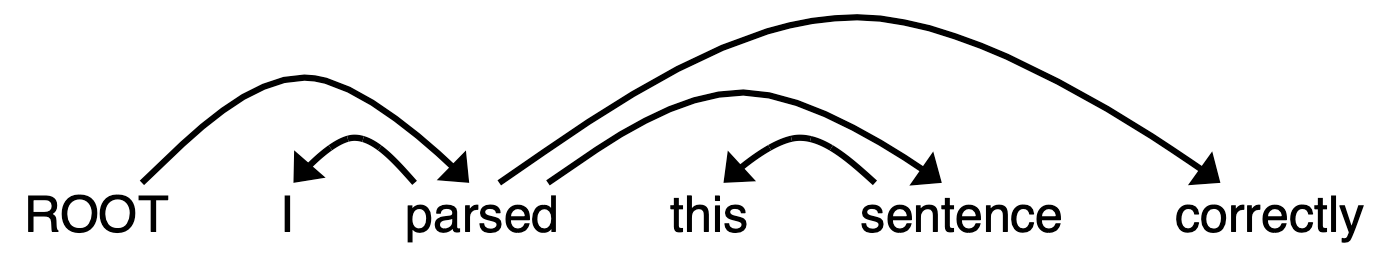

| Stack | Buffer | New dependency | Transition |
| :--   |  :--   | :--            | :--        |
| [ROOT] | [I, parsed, this, sentence, correctly] | | Init |
| [ROOT, I] | [parsed, this, sentence, correctly] | | SHIFT |
| [ROOT, I, parsed] | [this, sentence, correctly] | | SHIFT|
| [ROOT, parsed] | [this, sentence, correctly] | parsed $\rightarrow$ I | LEFTARC |

#### <font color="red">Write your answer here.</font> 


| Stack | Buffer | New dependency | Transition |
| :--   |  :--   | :--            | :--        |
| [ROOT] | [I, parsed, this, sentence, correctly] | | Init |
| [ROOT, I] | [parsed, this, sentence, correctly] | | SHIFT |
| [ROOT, I, parsed] | [this, sentence, correctly] | | SHIFT|
| [ROOT, parsed] | [this, sentence, correctly] | parsed $\rightarrow$ I | LEFTARC |
| [ROOT, parsed, this] | [sentence, correctly] | | SHIFT|
| [ROOT, parsed, this, sentence] | [correctly] | | SHIFT|
| [ROOT, parsed, sentence] | [correctly] |  sentence $\rightarrow$ this | LEFTARC|
| [ROOT, parsed] | [correctly] |  parsed $\rightarrow$ sentence | RIGHTARC|
| [ROOT, parsed, correctly] | [] | | SHIFT|
| [ROOT, parsed] | [] | parsed $\rightarrow$ correctly | RIGHTARC |
| [ROOT] | [] | root $\rightarrow$ parsed| RIGHTARC|

- (2 pts) A sentence containing $n$ words will be parsed in how many steps (in terms of $n$)?  Briefly explain in 1-2 sentences why.

#### <font color="red">Write your answer here.</font> 

As there are 2 possible steps for each word in the list: either shifting from the buffer to stack or clearing a dependent of the stack. The total number of steps would be $2*n$ steps


## Part 3:  Parser

- (6pts) Implement the <code>\_\_init\_\_</code> and <code>parse_step</code> functions in the <code>PartialParse</code> class below.  This implements the transition mechanics your parser will use.  

Test your function by running <code>test_parse_step()</code> followed by <code>test_parse()</code>

- (8pts) Our network will predict which transition should be applied next to a partial parse.  We could use it to parse a single sentence by applying predicted transitions until the parse is complete.  However, neural networks run much more efficiently when making predictions about batches of data (i.e., predicting the next transition for any different partial parses simultaneously).  We can parse sentences in minibatches with the following algorithm

**Input**: <code>sentences</code>, a list of sentences to be parsed and <code>model</code>, our model that makes parse decisions

1. Initialize <code>partial_parses</code> as a list of <code>PartialParses</code>, one for each sentence in <code>sentences</code>
2. Initailize <code>unfinished_parses</code> as a shallow copy of <code>partial_parses</code>
3. **while** <code>unfinished_parses</code> is not empty **do**
    - Take the first <code>batch_size</code> parses in <code>unfinished_parses</code> as a minibatch
    - Use the <code>model</code> to predict the next transition for each partial parse in the minitbatch
    - Peform a parse step on each partial parse in the minibatch with its predicted transition
    - Remove the completed (empty buffer and stack of size 1) parses from <code>unfinished_parses</code>
    
**Return**: The dependencies for each parse in <code>partial_parses</code>

Implement this algorithm in the <code>minibatch_parse</code> function below.

Test your function by running <code>test_minibatch_parse()</code>

In [5]:
class PartialParse(object):
    def __init__(self, sentence):
        """Initializes this partial parse.
        @param sentence (list of str): The sentence to be parsed as a list of words.
                                        Your code should not modify the sentence.
        """
        # The sentence being parsed is kept for bookkeeping purposes. Do not alter it in your code.
        self.sentence = sentence

        # YOUR CODE HERE (3 Lines)
        # Your code should initialize the following fields:
        # self.stack: The current stack represented as a list with the top of the stack as the
        # last element of the list.
        # self.buffer: The current buffer represented as a list with the first item on the
        # buffer as the first item of the list
        # self.dependencies: The list of dependencies produced so far. Represented as a list of
        # tuples where each tuple is of the form (head, dependent).
        # Order for this list doesn't matter.
        ###
        # Note: The root token should be represented with the string "ROOT"
        ###

        self.stack = ['ROOT']
        self.buffer = [word for word in self.sentence]
        self.dependencies = []
        
        
        
        
        

        # END YOUR CODE

    def parse_step(self, transition):
        """Performs a single parse step by applying the given transition to
           this partial parse.
        @param transition (str): A string that equals "S", "LA", or "RA"
                                 representing the shift, left-arc, and right-arc
                                 transitions. You can assume the provided
                                 transition is a legal transition.
        """

        # YOUR CODE HERE (~7-10 Lines)
        # TODO:
        # Implement a single parsing step, i.e. the logic for the following as
        # described in the pdf handout:
        # 1. Shift
        # 2. Left Arc
        # 3. Right Arc


        
        if transition == "S":
            self.stack.append(self.buffer[0])
            self.buffer.pop(0)
        
        elif transition  == "LA":
            self.dependencies.append((self.stack[-1], self.stack[-2]))
            self.stack.pop(-2)

        elif transition == "RA":
            self.dependencies.append((self.stack[-2], self.stack[-1]))
            self.stack.pop(-1)
        
        else:
            print('Wrong transition')

        

        # END YOUR CODE

    def parse(self, transitions):
        """Applies the provided transitions to this PartialParse
        @param transitions (list of str): The list of transitions in the order
                                          they should be applied.
        @return dsependencies (list of string tuples): The list of dependencies
                                                       produced when parsing the
                                                       sentence. Represented as
                                                       a list of tuples where each
                                                       tuple is of the form
                                                       (head, dependent).
        """
        for transition in transitions:
            self.parse_step(transition)
        return self.dependencies



    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)


def minibatch_parse(sentences, model, batch_size):
    """Parses a list of sentences in minibatches using a model.
    @param sentences (list of list of str): A list of sentences to be parsed
                                            (each sentence is a list of words
                                            and each word is of type string)
    @param model (ParserModel): The model that makes parsing decisions. It is
                                assumed to have a function
                                model.predict(partial_parses) that takes in a
                                list of PartialParses as input and
                                returns a list of transitions predicted for each
                                parse. That is, after calling
                                    transitions = model.predict(partial_parses)
                                transitions[i] will be the next transition to
                                apply to partial_parses[i].
    @param batch_size (int): The number of PartialParses to include in each minibatch
    @return dependencies (list of dependency lists): A list where each element
                                                     is the dependencies list for
                                                     parsed sentence. Ordering
                                                     should be the same as in
                                                     sentences (i.e.,
                                                     dependencies[i] should
                                                     contain the parse for
                                                     sentences[i]).
    """
    dependencies = []

    # YOUR CODE HERE (~8-10 Lines)
    # TODO:
    # Implement the minibatch parse algorithm
    ###
    # Note: A shallow copy can be made with the "=" sign
    # in python, e.g. unfinished_parses = partial_parses[:].
    # Here `unfinished_parses` is a shallow copy of `partial_parses`.
    # In Python, a shallow copied list like `unfinished_parses` does not contain
    # new instances of the object stored in `partial_parses`. Rather both lists
    # refer to the same objects.
    # In our case, `partial_parses` contains a list of partial parses.
    # `unfinished_parses` contains references to the same objects. Thus, you
    # should NOT use the `del` operator to remove objects from the
    # `unfinished_parses` list. This will free the underlying memory that
    # is being accessed by `partial_parses` and may cause your code to crash.

    
    partial_parse = [PartialParse(sentence) for sentence in sentences]
    # unfinished_parses = partial_parses
    # while len(unfinished_parses) > 0:
    #     cur_size = min(batch_size, len(unfinished_parses))
    #     batch_parses = unfinished_parses[:cur_size]
    #     batch_dependencies = [[] for i in range(cur_size)]
    #     pred_transitions = model.predict(batch_parses)
    #     copy = [parse for parse in batch_parses]
    #     for index, single_parse in enumerate(copy):
    #         batch_dependencies[index].extend(single_parse.parse([pred_transitions[index]]))
    #         if len(single_parse.buffer) == 0 and len(single_parse.stack) == 1:
    #             dependencies.append(batch_dependencies[index])
    #             unfinished_parses.remove(single_parse)
    
    
    while len(partial_parse) > 0:
        mini_batch = partial_parse[:batch_size]
        while len(mini_batch) > 0:
            transitions = model.predict(mini_batch)
            for i, action in enumerate(transitions):
                mini_batch[i].parse_step(action)
            mini_batch = [parse for parse in mini_batch if len(parse.stack) > 1 or len(parse.buffer) > 0]
        dependencies.extend(p.dependencies for p in partial_parse[:batch_size])
        partial_parse = partial_parse[batch_size:]
    


    # END YOUR CODE

    return dependencies


def test_step(name, transition, stack, buf, deps,
              ex_stack, ex_buf, ex_deps):
    """Tests that a single parse step returns the expected output"""
    pp = PartialParse([])
    pp.stack, pp.buffer, pp.dependencies = stack, buf, deps

    pp.parse_step(transition)
    stack, buf, deps = (tuple(pp.stack), tuple(pp.buffer),
                        tuple(sorted(pp.dependencies)))
    assert stack == ex_stack, \
        "{:} test resulted in stack {:}, expected {:}".format(
            name, stack, ex_stack)
    assert buf == ex_buf, \
        "{:} test resulted in buffer {:}, expected {:}".format(
            name, buf, ex_buf)
    assert deps == ex_deps, \
        "{:} test resulted in dependency list {:}, expected {:}".format(
            name, deps, ex_deps)
    print("{:} test passed!".format(name))


def test_parse_step():
    """Simple tests for the PartialParse.parse_step function
    Warning: these are not exhaustive
    """
    test_step("SHIFT", "S", ["ROOT", "the"], ["cat", "sat"], [],
              ("ROOT", "the", "cat"), ("sat",), ())
    test_step("LEFT-ARC", "LA", ["ROOT", "the", "cat"], ["sat"], [],
              ("ROOT", "cat",), ("sat",), (("cat", "the"),))
    test_step("RIGHT-ARC", "RA", ["ROOT", "run", "fast"], [], [],
              ("ROOT", "run",), (), (("run", "fast"),))


def test_parse():
    """Simple tests for the PartialParse.parse function
    Warning: these are not exhaustive
    """
    sentence = ["parse", "this", "sentence"]
    dependencies = PartialParse(sentence).parse(
        ["S", "S", "S", "LA", "RA", "RA"])
    dependencies = tuple(sorted(dependencies))
    expected = (('ROOT', 'parse'), ('parse', 'sentence'), ('sentence', 'this'))
    assert dependencies == expected,  \
        "parse test resulted in dependencies {:}, expected {:}".format(
            dependencies, expected)
    assert tuple(sentence) == ("parse", "this", "sentence"), \
        "parse test failed: the input sentence should not be modified"
    print("parse test passed!")

class DummyModel(object):
    """Dummy model for testing the minibatch_parse function
    First shifts everything onto the stack and then does exclusively right arcs if the first word of
    the sentence is "right", "left" if otherwise.
    """

    def predict(self, partial_parses):
        return [("RA" if pp.stack[1] == "right" else "LA") if len(pp.buffer) == 0 else "S"
                for pp in partial_parses]


def test_dependencies(name, deps, ex_deps):
    """Tests the provided dependencies match the expected dependencies"""
    deps = tuple(sorted(deps))
    assert deps == ex_deps, \
        "{:} test resulted in dependency list {:}, expected {:}".format(
            name, deps, ex_deps)


def test_minibatch_parse():
    """Simple tests for the minibatch_parse function
    Warning: these are not exhaustive
    """
    sentences = [["right", "arcs", "only"],
                 ["right", "arcs", "only", "again"],
                 ["left", "arcs", "only"],
                 ["left", "arcs", "only", "again"]]
    deps = minibatch_parse(sentences, DummyModel(), 2)
    test_dependencies("minibatch_parse", deps[0],
                      (('ROOT', 'right'), ('arcs', 'only'), ('right', 'arcs')))
    test_dependencies("minibatch_parse", deps[1],
                      (('ROOT', 'right'), ('arcs', 'only'), ('only', 'again'), ('right', 'arcs')))
    test_dependencies("minibatch_parse", deps[2],
                      (('only', 'ROOT'), ('only', 'arcs'), ('only', 'left')))
    test_dependencies("minibatch_parse", deps[3],
                      (('again', 'ROOT'), ('again', 'arcs'), ('again', 'left'), ('again', 'only')))
    print("minibatch_parse test passed!")

Test your function by running <code>test_parse_step()</code> followed by <code>test_parse()</code>

In [6]:
#testing your parse_step
#turn on when you are ready
test_parse_step()
test_parse

SHIFT test passed!
LEFT-ARC test passed!
RIGHT-ARC test passed!


<function __main__.test_parse>

Test your function by running <code>test_minibatch_parse()</code>

In [7]:
#testing your minibatch_parse
#turn on when you are ready
test_minibatch_parse()

minibatch_parse test passed!


## Part 4: Neural Network

Let's train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next.

First, the model extracts a feature vector representing the current state.  We will be using the feature set presented in *A Fast and Accurate Dependency Parser using Neural Networks (Chen and Manning 2014)*.  The function extracting these features are implemented for you here below.

This feature vector consists of a list of tokens (e.g., the last work in the stack, first word in the buffer, dependent of the second-to-last word in the stack if there is one, etc.). They can be represented as a list of integers $\mathbf{w} = [w_1, w_2, \cdots, w_m]$ where $m$ is the number of features and each $0 \leq w_i \leq |V|$ is the index of a token in the vocabulary ($|V|$ is the vocabulary size).  Then our network looks up an embedding for each word and concatenates them into a single input vector:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

We then compute our prediction as:

$$\mathbf{h} = \text{ReLU}(\mathbf{xW} + \mathbf{b}_1)$$
$$\mathbf{l} = \mathbf{hU} + \mathbf{b}_2$$
$$\hat{\mathbf{y}} = \text{softmax}(l)$$

where $\mathbf{h}$ is referred to as the hidden layer, $\mathbf{l}$ is the logits, $\hat{\mathbf{y}}$ is the predictions, and $\text{ReLU}(z) = \text{max}(z, 0))$.  We will then train the model to minimize cross-entropy (CE) loss:

$$J(\theta) = \text{CE}(\mathbf{y}, \hat{\mathbf{y}}) = -\sum_{i=1}^{3}y_i \log \hat{y}_i$$

To compute the loss for the training set, we average this $J(\theta)$ across all training examples.  We will use UAS (Unlabeled Attachment Score) as main metric, which is computed as the ratio between number of correctly predicted dependencies and the number of total dependencies despite of the relations (our model doesn't predict this). 

Below this code, you will find a skeleton code to implement this network using PyTorch.  Complete the <code>\_\_init\_\_</code>, <code>embedding_lookup</code> and <code>forward</code> functions to implement the model.  Then complete the <code>train_for_epoch</code> and <code>train</code> functions to actually train the model.

In [8]:
#do not change this code; this is provided for you which helps extract features from the stack, buffers and dependencies"

P_PREFIX = '<p>:'
L_PREFIX = '<l>:'
UNK = '<UNK>'
NULL = '<NULL>'
ROOT = '<ROOT>'

def get_minibatches(data, minibatch_size, shuffle=True):
    """
    Iterates through the provided data one minibatch at at time. You can use this function to
    iterate through data in minibatches as follows:

        for inputs_minibatch in get_minibatches(inputs, minibatch_size):
            ...

    Or with multiple data sources:

        for inputs_minibatch, labels_minibatch in get_minibatches([inputs, labels], minibatch_size):
            ...

    Args:
        data: there are two possible values:
            - a list or numpy array
            - a list where each element is either a list or numpy array
        minibatch_size: the maximum number of items in a minibatch
        shuffle: whether to randomize the order of returned data
    Returns:
        minibatches: the return value depends on data:
            - If data is a list/array it yields the next minibatch of data.
            - If data a list of lists/arrays it returns the next minibatch of each element in the
              list. This can be used to iterate through multiple data sources
              (e.g., features and labels) at the same time.

    """
    list_data = type(data) is list and (type(data[0]) is list or type(data[0]) is np.ndarray)
    data_size = len(data[0]) if list_data else len(data)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data] if list_data \
            else _minibatch(data, minibatch_indices)


def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]


def test_all_close(name, actual, expected):
    if actual.shape != expected.shape:
        raise ValueError("{:} failed, expected output to have shape {:} but has shape {:}"
                         .format(name, expected.shape, actual.shape))
    if np.amax(np.fabs(actual - expected)) > 1e-6:
        raise ValueError("{:} failed, expected {:} but value is {:}".format(name, expected, actual))
    else:
        print(name, "passed!")


class Config(object):
    language = 'english'
    with_punct = True
    unlabeled = True
    lowercase = True
    use_pos = True
    use_dep = True
    use_dep = use_dep and (not unlabeled)
    data_path = './data-a3'
    train_file = 'train.conll'
    dev_file = 'dev.conll'
    test_file = 'test.conll'
    embedding_file = './data-a3/en-cw.txt'


class Parser(object):
    """Contains everything needed for transition-based dependency parsing except for the model"""

    def __init__(self, dataset):
        root_labels = list([l for ex in dataset
                           for (h, l) in zip(ex['head'], ex['label']) if h == 0])
        counter = Counter(root_labels)
        if len(counter) > 1:
            logging.info('Warning: more than one root label')
            logging.info(counter)
        self.root_label = counter.most_common()[0][0]
        deprel = [self.root_label] + list(set([w for ex in dataset
                                               for w in ex['label']
                                               if w != self.root_label]))
        tok2id = {L_PREFIX + l: i for (i, l) in enumerate(deprel)}
        tok2id[L_PREFIX + NULL] = self.L_NULL = len(tok2id)

        config = Config()
        self.unlabeled = config.unlabeled
        self.with_punct = config.with_punct
        self.use_pos = config.use_pos
        self.use_dep = config.use_dep
        self.language = config.language

        if self.unlabeled:
            trans = ['L', 'R', 'S']
            self.n_deprel = 1
        else:
            trans = ['L-' + l for l in deprel] + ['R-' + l for l in deprel] + ['S']
            self.n_deprel = len(deprel)

        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}
        self.id2tran = {i: t for (i, t) in enumerate(trans)}

        # logging.info('Build dictionary for part-of-speech tags.')
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK] = self.P_UNK = len(tok2id)
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)

        # logging.info('Build dictionary for words.')
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK] = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)

        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}

        self.n_features = 18 + (18 if config.use_pos else 0) + (12 if config.use_dep else 0)
        self.n_tokens = len(tok2id)

    def vectorize(self, examples):
        vec_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            label = [-1] + [self.tok2id[L_PREFIX + w] if L_PREFIX + w in self.tok2id
                            else -1 for w in ex['label']]
            vec_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'label': label})
        return vec_examples

    def extract_features(self, stack, buf, arcs, ex):
        if stack[0] == "ROOT":
            stack[0] = 0

        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = []
        l_features = []
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        if self.use_pos:
            p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
            p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))

        for i in range(2):
            if i < len(stack):
                k = stack[-i-1]
                lc = get_lc(k)
                rc = get_rc(k)
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                if self.use_pos:
                    p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)

                if self.use_dep:
                    l_features.append(ex['label'][lc[0]] if len(lc) > 0 else self.L_NULL)
                    l_features.append(ex['label'][rc[0]] if len(rc) > 0 else self.L_NULL)
                    l_features.append(ex['label'][lc[1]] if len(lc) > 1 else self.L_NULL)
                    l_features.append(ex['label'][rc[1]] if len(rc) > 1 else self.L_NULL)
                    l_features.append(ex['label'][llc[0]] if len(llc) > 0 else self.L_NULL)
                    l_features.append(ex['label'][rrc[0]] if len(rrc) > 0 else self.L_NULL)
            else:
                features += [self.NULL] * 6
                if self.use_pos:
                    p_features += [self.P_NULL] * 6
                if self.use_dep:
                    l_features += [self.L_NULL] * 6

        features += p_features + l_features
        assert len(features) == self.n_features
        return features

    def get_oracle(self, stack, buf, ex):
        if len(stack) < 2:
            return self.n_trans - 1

        i0 = stack[-1]
        i1 = stack[-2]
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        l0 = ex['label'][i0]
        l1 = ex['label'][i1]

        if self.unlabeled:
            if (i1 > 0) and (h1 == i0):
                return 0
            elif (i1 >= 0) and (h0 == i1) and \
                 (not any([x for x in buf if ex['head'][x] == i0])):
                return 1
            else:
                return None if len(buf) == 0 else 2
        else:
            if (i1 > 0) and (h1 == i0):
                return l1 if (l1 >= 0) and (l1 < self.n_deprel) else None
            elif (i1 >= 0) and (h0 == i1) and \
                 (not any([x for x in buf if ex['head'][x] == i0])):
                return l0 + self.n_deprel if (l0 >= 0) and (l0 < self.n_deprel) else None
            else:
                return None if len(buf) == 0 else self.n_trans - 1

    def create_instances(self, examples):
        all_instances = []
        succ = 0
        for id, ex in enumerate(examples):
            n_words = len(ex['word']) - 1

            # arcs = {(h, t, label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]
            arcs = []
            instances = []
            for i in range(n_words * 2):
                gold_t = self.get_oracle(stack, buf, ex)
                if gold_t is None:
                    break
                legal_labels = self.legal_labels(stack, buf)
                assert legal_labels[gold_t] == 1
                instances.append((self.extract_features(stack, buf, arcs, ex),
                                  legal_labels, gold_t))
                if gold_t == self.n_trans - 1:
                    stack.append(buf[0])
                    buf = buf[1:]
                elif gold_t < self.n_deprel:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                succ += 1
                all_instances += instances

        return all_instances

    def legal_labels(self, stack, buf):
        labels = ([1] if len(stack) > 2 else [0]) * self.n_deprel
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel
        labels += [1] if len(buf) > 0 else [0]
        return labels

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        for i, example in enumerate(dataset):
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]
            sentences.append(sentence)
            sentence_id_to_idx[id(sentence)] = i

        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)

        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['label'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (self.with_punct) or (not punct(self.language, pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies


class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dependencies,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        return pred


def read_conll(in_file, lowercase=False, max_example=None):
    examples = []
    with open(in_file) as f:
        word, pos, head, label = [], [], [], []
        for line in f.readlines():
            sp = line.strip().split('\t')
            if len(sp) == 10:
                if '-' not in sp[0]:
                    word.append(sp[1].lower() if lowercase else sp[1])
                    pos.append(sp[4])
                    head.append(int(sp[6]))
                    label.append(sp[7])
            elif len(word) > 0:
                examples.append({'word': word, 'pos': pos, 'head': head, 'label': label})
                word, pos, head, label = [], [], [], []
                if (max_example is not None) and (len(examples) == max_example):
                    break
        if len(word) > 0:
            examples.append({'word': word, 'pos': pos, 'head': head, 'label': label})
    return examples


def build_dict(keys, n_max=None, offset=0):
    count = Counter()
    for key in keys:
        count[key] += 1
    ls = count.most_common() if n_max is None \
        else count.most_common(n_max)

    return {w[0]: index + offset for (index, w) in enumerate(ls)}


def punct(language, pos):
    if language == 'english':
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    elif language == 'chinese':
        return pos == 'PU'
    elif language == 'french':
        return pos == 'PUNC'
    elif language == 'german':
        return pos in ["$.", "$,", "$["]
    elif language == 'spanish':
        # http://nlp.stanford.edu/software/spanish-faq.shtml
        return pos in ["f0", "faa", "fat", "fc", "fd", "fe", "fg", "fh",
                       "fia", "fit", "fp", "fpa", "fpt", "fs", "ft",
                       "fx", "fz"]
    elif language == 'universal':
        return pos == 'PUNCT'
    else:
        raise ValueError('language: %s is not supported.' % language)


def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)


def load_and_preprocess_data(reduced=True):
    config = Config()

    print("Loading data...",)
    start = time.time()
    train_set = read_conll(os.path.join(config.data_path, config.train_file),
                           lowercase=config.lowercase)
    dev_set = read_conll(os.path.join(config.data_path, config.dev_file),
                         lowercase=config.lowercase)
    test_set = read_conll(os.path.join(config.data_path, config.test_file),
                          lowercase=config.lowercase)
    if reduced:
        train_set = train_set[:1000]
        dev_set = dev_set[:500]
        test_set = test_set[:500]
    print("took {:.2f} seconds".format(time.time() - start))

    print("Building parser...",)
    start = time.time()
    parser = Parser(train_set)
    print("took {:.2f} seconds".format(time.time() - start))

    print("Loading pretrained embeddings...",)
    start = time.time()
    word_vectors = {}
    for line in open(config.embedding_file).readlines():
        sp = line.strip().split()
        word_vectors[sp[0]] = [float(x) for x in sp[1:]]
    embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

    for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
    print("took {:.2f} seconds".format(time.time() - start))

    print("Vectorizing data...",)
    start = time.time()
    train_set = parser.vectorize(train_set)
    dev_set = parser.vectorize(dev_set)
    test_set = parser.vectorize(test_set)
    print("took {:.2f} seconds".format(time.time() - start))

    print("Preprocessing training data...",)
    start = time.time()
    train_examples = parser.create_instances(train_set)
    print("took {:.2f} seconds".format(time.time() - start))

    return parser, embeddings_matrix, train_examples, dev_set, test_set,


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


if __name__ == '__main__':
    pass

So here is the skeleton code to implement this network using PyTorch.  Complete the <code>\_\_init\_\_</code>, <code>embedding_lookup</code> and <code>forward</code> functions to implement the model. 

Please DO NOT use <code>torch.nn.Linear</code> or <code>torch.nn.Embedding</code>.  We are basically asking you to implement the Linear layer and Embedding layer by yourself so you can adjust the code according to the equation we got.

Please also follow the naming requirements in our TODO to avoid any problems.  

**Hints**
- Each of the variable (<code>self.embed_to_hidden_weight, self.embed_to_hidden_bias, self.hidden_to_logits_weight, self.hidden_to_logits_bias</code>) corresponds to ($\mathbf{W}, \mathbf{b}_1, \mathbf{U}, \mathbf{b}_2$)
- It may help to work backwards in the algorithm (start from $\hat{\mathbf{y}}$) and keep track of the matrix/vector shapes
- At worst, loss should be smaller than 0.08, and UAS larger than 87 on the dev set (around :-)). The original paper got around 92.5 UAS.
- Should take around 1 hour to train the model on the entire dataset

In [9]:
class ParserModel(nn.Module):
    """ Feedforward neural network with an embedding layer and single hidden layer.
    The ParserModel will predict which transition should be applied to a
    given partial parse configuration.
    PyTorch Notes:
        - Note that "ParserModel" is a subclass of the "nn.Module" class. In 
          PyTorch all neural networks
            are a subclass of this "nn.Module".
        - The "__init__" method is where you define all the layers and their 
          respective parameters (embedding layers, linear layers, dropout layers, etc.).
        - "__init__" gets automatically called when you create a new instance 
          of your class, e.g. when you write "m = ParserModel()".
        - Other methods of ParserModel can access variables that have "self." 
          prefix. Thus, you should add the "self." prefix layers, values, etc. 
          that you want to utilize in other ParserModel methods.
        - For further documentation on "nn.Module" please see
          https://pytorch.org/docs/stable/nn.html.
    """

    def __init__(self, embeddings, n_features=36,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):
        """ Initialize the parser model.
        @param embeddings (Tensor): word embeddings (num_words, embedding_size)
        @param n_features (int): number of input features
        @param hidden_size (int): number of hidden units
        @param n_classes (int): number of output classes
        @param dropout_prob (float): dropout probability
        """
        super(ParserModel, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size = embeddings.shape[1]
        self.hidden_size = hidden_size
        self.pretrained_embeddings = nn.Embedding(
            embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(
            torch.tensor(embeddings))

        # YOUR CODE HERE (~5 Lines)
        # TODO:
        # 1) Construct `self.embed_to_hidden` linear layer, initializing the weight matrix
        # with the `nn.init.xavier_uniform_` function with `gain = 1` (default)
        # 2) Construct `self.dropout` layer.
        # 3) Construct `self.hidden_to_logits` linear layer, initializing the weight matrix
        # with the `nn.init.xavier_uniform_` function with `gain = 1` (default)
        ###
        # Note: Here, we use Xavier Uniform Initialization for our Weight initialization.
        # It has been shown empirically, that this provides better initial weights
        # for training networks than random uniform initialization.
        # For more details checkout this great blogpost:
        # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
        # Hints:
        # - After you create a linear layer you can access the weight
        # matrix via:
        # linear_layer.weight
        ###
        # Please see the following docs for support:
        # Linear Layer: https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        # Xavier Init: https://pytorch.org/docs/stable/nn.html#torch.nn.init.xavier_uniform_
        # Dropout: https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout

        self.embed_to_hidden = nn.Linear(self.n_features * self.embed_size, self.hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight)
        self.dropout = nn.Dropout(p=self.dropout_prob)
        self.hidden_to_logits = nn.Linear(self.hidden_size, self.n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)
        
        
        

        # END YOUR CODE

    def embedding_lookup(self, t):
        """ Utilize `self.pretrained_embeddings` to map input `t` from input tokens
            (integers) to embedding vectors.
            PyTorch Notes:
                - `self.pretrained_embeddings` is a torch.nn.Embedding object 
                  that we defined in __init__
                - Here `t` is a tensor where each row represents a list of 
                  features. Each feature is represented by an integer (input token).
                - In PyTorch the Embedding object, e.g. 
                  `self.pretrained_embeddings`, allows you to
                  go from an index to embedding. Please see the documentation
                  (https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding)
                  to learn how to use `self.pretrained_embeddings` to extract 
                  the embeddings for your tensor `t`.
            @param t (Tensor): input tensor of tokens (batch_size, n_features)
            @return x (Tensor): tensor of embeddings for words represented in t
                                (batch_size, n_features * embed_size)
        """
        # YOUR CODE HERE (~1-3 Lines)
        # TODO:
        # 1) Use `self.pretrained_embeddings` to lookup the embeddings for the
        # input tokens in `t`.
        # 2) After you apply the embedding lookup, you will have a tensor shape
        # (batch_size, n_features, embedding_size).
        # Use the tensor `view` or `reshape` method to reshape the embeddings tensor to
        # (batch_size, n_features * embedding_size)
        ###
        # Note: In order to get batch_size, you may need use the tensor .size()
        # function:
        # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.size
        ###
        # Please see the following docs for support:
        # Embedding Layer: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        # View: https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

        
        # embed = self.pretrained_embeddings(t)
        # embed_shape = embed.size() #(batch_size, n_features, embedding_size).
        # x = embed.view((embed_shape[0],embed_shape[1]*embed_shape[2]))
        
        
        x = self.pretrained_embeddings(t)
        batch_size = t.shape[0]
        x = x.view(batch_size, -1)


    
        # END YOUR CODE
        return x

    def forward(self, t):
        """ Run the model forward.
            Note that we will not apply the softmax function here because it is 
            included in the loss function nn.CrossEntropyLoss
            PyTorch Notes:
                - Every nn.Module object (PyTorch model) has a `forward` 
                  function.
                - When you apply your nn.Module to an input tensor `t` this 
                  function is applied to the tensor.
                  For example, if you created an instance of your ParserModel 
                  and applied it to some `t` as follows, the `forward` function 
                  would called on `t` and the result would be stored in the 
                  `output` variable:
                        model = ParserModel()
                        output = model(t) # this calls the forward function
                # torch.nn.Module.forward
                - For more details checkout: https://pytorch.org/docs/stable/nn.html
        @param t (Tensor): input tensor of tokens (batch_size, n_features)
        @return logits (Tensor): tensor of predictions (output after applying 
                                 the layers of the network) without applying 
                                 softmax (batch_size, n_classes)
        """
        # YOUR CODE HERE (~3-5 lines)
        # TODO:
        # 1) Apply `self.embedding_lookup` to `t` to get the embeddings
        # 2) Apply `embed_to_hidden` linear layer to the embeddings
        # 3) Apply relu non-linearity to the output of step 2 to get the hidden units.
        # 4) Apply dropout layer to the output of step 3.
        # 5) Apply `hidden_to_logits` layer to the output of step 4 to get the logits.
        ###
        # Note: We do not apply the softmax to the logits here, because
        # the loss function (torch.nn.CrossEntropyLoss) applies it more efficiently.
        ###
        # Please see the following docs for support:
        # ReLU: https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.functional.relu

        
        # x = self.embedding_lookup(t)
        # x = self.embed_to_hidden(x)
        # x = nn.functional.relu(x)
        # x = self.dropout(x)
        # logits = self.hidden_to_logits(x)
        
        embeddings = self.embedding_lookup(t)
        t = self.embed_to_hidden(embeddings)
        relu = nn.ReLU()
        t = relu(t)
        t = self.dropout(t)
        logits = self.hidden_to_logits(t)
        
        
        

        # END YOUR CODE
        return logits

Now complete the <code>train_for_epoch</code> and <code>train</code> functions to actually train the model.

In [10]:
# -----------------
# Primary Functions
# -----------------


def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    """ Train the neural dependency parser.
    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param output_path (str): Path to which model weights and results are written.
    @param batch_size (int): Number of examples in a single batch
    @param n_epochs (int): Number of training epochs
    @param lr (float): Learning rate
    """
    best_dev_UAS = 0

    # YOUR CODE HERE (2 lines)
    # TODO:
    # 1) Construct Adam Optimizer in variable `optimizer`
    # 2) Construct the Cross Entropy Loss Function in variable `loss_func`
    ###
    # Hint: Use `parser.model.parameters()` to pass optimizer
    # necessary parameters to tune.
    # Please see the following docs for support:
    # Adam Optimizer: https://pytorch.org/docs/stable/optim.html
    # Cross Entropy Loss: https://pytorch.org/docs/stable/nn.html#crossentropyloss

    
    
    optimizer = torch.optim.Adam(parser.model.parameters(), lr)
    loss_func = nn.CrossEntropyLoss()
    
    

    # END YOUR CODE

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    """ Train the neural dependency parser for single epoch.
    Note: In PyTorch we can signify train versus test and automatically have
    the Dropout Layer applied and removed, accordingly, by specifying
    whether we are training, `model.train()`, or evaluating, `model.eval()`
    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param optimizer (nn.Optimizer): Adam Optimizer
    @param loss_func (nn.CrossEntropyLoss): Cross Entropy Loss Function
    @param batch_size (int): batch size
    @param lr (float): learning rate
    @return dev_UAS (float): Unlabeled Attachment Score (UAS) for dev data
    """
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            optimizer.zero_grad()   # remove any baggage in the optimizer
            loss = 0.  # store loss for this batch here
            train_x = torch.from_numpy(train_x).long()
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()

            # YOUR CODE HERE (~5-10 lines)
            # TODO:
            # 1) Run train_x forward through model to produce `logits`
            # 2) Use the `loss_func` parameter to apply the PyTorch CrossEntropyLoss function.
            # This will take `logits` and `train_y` as inputs. It will output the CrossEntropyLoss
            # between softmax(`logits`) and `train_y`. Remember that softmax(`logits`)
            # are the predictions (y^ from the PDF).
            # 3) Backprop losses
            # 4) Take step with the optimizer
            # Please see the following docs for support:
            # Optimizer Step: https://pytorch.org/docs/stable/optim.html#optimizer-step

            
            
            logits = parser.model.forward(train_x)
            loss = loss_func(logits, train_y)
            loss.backward()
            optimizer.step()
  
            
            
            # END YOUR CODE
            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))

    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

## Part 5: Evaluation

Now execute this code to actually train your model and compute predictions on test data from Penn Treebank (annotated with Universal Dependencies)

In [11]:
# Note: Set debug to False, when training on entire corpus
debug = True
# debug = False

print(80 * "=")
print("INITIALIZING")
print(80 * "=")
parser, embeddings, train_data, dev_data, test_data = load_and_preprocess_data(
    debug)

start = time.time()
model = ParserModel(embeddings)
parser.model = model
print("took {:.2f} seconds\n".format(time.time() - start))

print(80 * "=")
print("TRAINING")
print(80 * "=")
output_dir = "results/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

train(parser, train_data, dev_data, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

if not debug:
    print(80 * "=")
    print("TESTING")
    print(80 * "=")
    print("Restoring the best model weights found on the dev set")
    parser.model.load_state_dict(torch.load(output_path))
    print("Final evaluation on test set",)
    parser.model.eval()
    UAS, dependencies = parser.parse(test_data)
    print("- test UAS: {:.2f}".format(UAS * 100.0))
    print("Done!")

INITIALIZING
Loading data...
took 2.42 seconds
Building parser...
took 0.04 seconds
Loading pretrained embeddings...
took 2.54 seconds
Vectorizing data...
took 0.26 seconds
Preprocessing training data...
took 1.47 seconds
took 0.10 seconds

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:05<00:00,  9.48it/s]


Average Train Loss: 0.6397931215663751
Evaluating on dev set


125250it [00:00, 8831264.10it/s]       


- dev UAS: 53.29
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:04<00:00,  9.93it/s]


Average Train Loss: 0.3289121842632691
Evaluating on dev set


125250it [00:00, 9741443.70it/s]       


- dev UAS: 59.99
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:04<00:00,  9.75it/s]


Average Train Loss: 0.2638066317886114
Evaluating on dev set


125250it [00:00, 7606187.85it/s]       


- dev UAS: 63.03
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.21it/s]


Average Train Loss: 0.22698661964386702
Evaluating on dev set


125250it [00:00, 9460410.16it/s]       


- dev UAS: 65.48
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.08it/s]


Average Train Loss: 0.20008880427728096
Evaluating on dev set


125250it [00:00, 7538732.52it/s]       


- dev UAS: 67.36
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.25it/s]


Average Train Loss: 0.1794545939192176
Evaluating on dev set


125250it [00:00, 8220843.72it/s]       


- dev UAS: 67.79
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.11it/s]


Average Train Loss: 0.1569168840845426
Evaluating on dev set


125250it [00:00, 5385581.79it/s]       


- dev UAS: 69.51
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:04<00:00,  9.84it/s]


Average Train Loss: 0.1432847360459467
Evaluating on dev set


125250it [00:00, 6941642.67it/s]       


- dev UAS: 70.15
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.34it/s]


Average Train Loss: 0.13280397187918425
Evaluating on dev set


125250it [00:00, 9423415.66it/s]       


- dev UAS: 71.42
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:04<00:00, 10.22it/s]


Average Train Loss: 0.12150807104383905
Evaluating on dev set


125250it [00:00, 6746241.55it/s]       

- dev UAS: 71.64
New best dev UAS! Saving model.

